In [1]:
import os
import glob
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [33]:
# Read in the data
data_root = '/mnt/mnemo5/sum02dean/sl_projects/MLG/task_1/data/CAGE-train'
files_train = glob.glob(os.path.join(data_root, '*train_y.tsv'))
files_val = glob.glob(os.path.join(data_root, '*val_y.tsv'))

# Get train and test
df_train = pd.concat([pd.read_csv(x, sep='\t') for x in files_train])
df_val= pd.concat([pd.read_csv(x, sep='\t') for x in files_val])


In [34]:
def plot_distribution(x1, x2, min_v=-300, max_v=800, balance=True, names=['test', 'train']):
    """Plots the distribution between two variables of interest, x1 and x2.

    :param x1: variable 1 (smallest number of samples - if balance = True)
    :type x1: pandas.core.frame.DataFrame 
    
    :param x2: variable 2  (lagestest number of samples - if balance = True)
    :type x2: pandas.core.frame.DataFrame

    :param names: list containing strings of dataset names (for plotting) in same order provided
    :type names: list

    :param balace: to balance the sets based on x1 dimension (dim 0), defaults to True
    :type balace: bool, optional
    """

    if balance:
        try:
            # Check length of x1 <= x2
            assert(x1.shape[0] <= x2.shape[0])

            # Balance data
            n_samples = np.shape(x1)[0]
            x2 = x2.sample(n_samples)  

        except AssertionError as e:
            print(e)
            print('Make sure x2 has largest number of samples!')
            return None

    # Plot KDE
    fig, ax = plt.subplots()
    sns.kdeplot(x1['gex'].values, label=names[0])
    sns.kdeplot(x2['gex'].values, label=names[1])
    plt.title("GEX Distributions ({}-{})".format(names[0], names[1]))
    plt.xlim([min_v, max_v])
    ax.legend()
    plt.show()


    


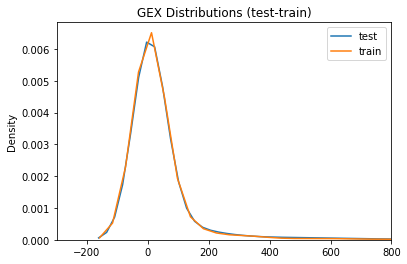

In [37]:
plot_distribution(x1=df_val, x2=df_train, balance=True, names=['test', 'train'])

In [36]:
df_val

,gene_name,gex
0,ECH1,0.000000
1,CAMSAP3,0.000000
2,MISP,0.000000
3,MCOLN1,0.000000
4,CHERP,0.480536
...,...,...
1969,TMPRSS9,0.000000
1970,PSMA3,0.096071
1971,PLEKHA4,0.000000
1972,DENND1C,0.000000
